#### 分析debiased后不平衡数据集上降低的精度是否属于过拟合得到的精度

In [1]:
import torch
import pandas as pd
import numpy as np
# 1. 获取在这些数据集上debiased前后的预测值，并找出来debiased后回答不对的样本
def get_rectified_examples(root_dir, model, prompt):
    """统计不同数据集的recall ratio"""
    # k = [0,1,2,4,8,16,32]
    num = 0

    
    if prompt != "optiprompt":
        data_dir = f"{root_dir}/manual_prompt/filter_out_{num}_biased_tokens/{model}/{prompt}/debias_answer_type_tokens/origin_embedding/ablations/no_norm_no_rescale/preds.pt"
    else:
        data_dir = f"{root_dir}/continue_prompt/filter_out_{num}_biased_tokens/{model}/{prompt}_5/debias_answer_type_tokens/origin_embedding/ablations/no_norm_no_rescale/exp_1/preds.pt"
    # 数据集数量变化
    raw_data = torch.load(data_dir)
    datasets = ["LAMA", "LAMA-WHU"]
    rectified_data = {}
    for _ in datasets:
        dataset = raw_data[_]
        
        # 计算某个relation的公共进度
        preds_df = {}
        for rel in dataset.keys():
            data = dataset[rel]['data']
            data.pop("raw_probs",None)
            data.pop("debiased_probs",None)
            preds_df[rel] = pd.DataFrame({key: value if type(value)!=torch.Tensor else value.cpu() for key,value in data.items()})
        rectified_df = {}
        for rel in dataset.keys():
            df = preds_df[rel]
            # 找到原来对了，debias错误的数据
            rectified_example = df.query("obj_labels==raw_preds and obj_labels!=debiased_preds")
            # raw_num_df = df.query("obj_labels==raw_preds")
            # acc = recall_ratio.shape[0]/df.shape[0]
            # recall_ratios[rel] = acc
            rectified_df[rel] = rectified_example

        rectified_data[_] = rectified_df
    return rectified_data



In [2]:
# 2. 获取prompt bias在answer space上的概率分布
import torch
bias_results = torch.load("model_bias.pt")

In [3]:
# 3. 判断回答不对的样本的label是否属于bias最大的token，以及是否属于bias超过unifrom的token
top_k = 0 # bias最大token
top_k = -1 # 超过unifrom的token
root_dir = "/mnt/code/users/xuziyang/PromptBias/outputs/openprompt"


models = ["bert-base-cased","bert-large-cased","roberta-large"]
prompts = ["LAMA","LPAQA","AutoPrompt","optiprompt"]
benchmark = "LAMA"
results = {}
for model in models:
    results[model] = {}
    for prompt in prompts:
        data = get_rectified_examples(root_dir, model,prompt)[benchmark]
        collect = []
        for rel in data.keys():
            labels_sub_ids = data[rel]["label_subvocab_ids"].tolist()
            logits, bias_vector = bias_results[model][prompt][rel]
            # 从逻辑值->概率值
            norm2 = torch.norm(bias_vector)
            probs = torch.softmax(logits*norm2, dim=-1).tolist()
            sample_space_size = len(probs)
            if top_k == 0:
                index = [np.argmax(probs).tolist()]
            elif top_k == -1:
                random_p = 1 / sample_space_size
                prompt_biased_indices = (torch.Tensor(probs) > random_p).nonzero().view(-1)
                index = prompt_biased_indices.tolist()
            else:
                assert False
            
            if len(labels_sub_ids) != 0:
                ratio = np.sum([1 if i in index else 0 for i in labels_sub_ids]) / len(labels_sub_ids)
                collect.append(ratio)

            
            
        avg_ratio = np.mean(collect)

        results[model][prompt] = avg_ratio


print(results)

{'bert-base-cased': {'LAMA': 0.8501642660068836, 'LPAQA': 0.8930796530647157, 'AutoPrompt': 0.9144750978671405, 'optiprompt': 0.8962028311786832}, 'bert-large-cased': {'LAMA': 0.7796843464539046, 'LPAQA': 0.8327183847551741, 'AutoPrompt': 0.8660165347513166, 'optiprompt': 0.8924721949690114}, 'roberta-large': {'LAMA': 0.805031352120705, 'LPAQA': 0.8077772586964519, 'AutoPrompt': 0.9102598305621535, 'optiprompt': 0.9023572867123203}}


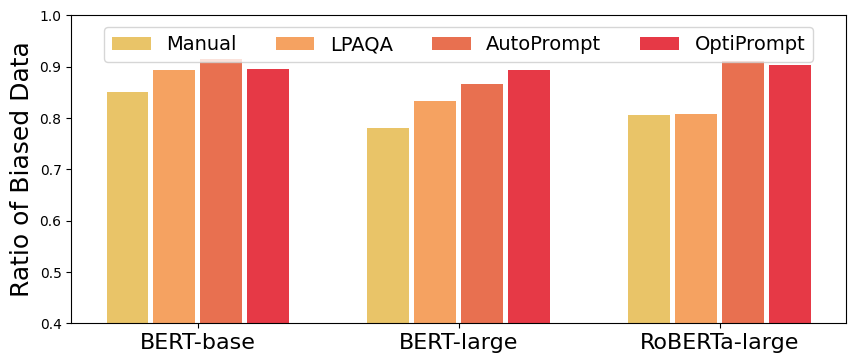

In [28]:
# 可视化，画个图

import matplotlib.pyplot as plt
import numpy as np

# 数据
models = ['bert-base', 'bert-large', 'roterba-large']
methods = ['Manual', 'LPAQA', 'AutoPrompt', 'OptiPrompt']
data = results

# 新颜色
colors = ['#E9C468', '#F5A261', '#E87050', '#E63946']

# 柱状图设置
width = 0.16
pad = 0.02
x = np.arange(len(models))

fig, ax = plt.subplots(figsize=(10, 4))  # 增加图表宽度

for i, method in enumerate(methods):
    prompt = ["LAMA","LPAQA","AutoPrompt","optiprompt"][methods.index(method)]
    models = ["bert-base-cased","bert-large-cased","roberta-large"]
    models_legend = ["BERT-base","BERT-large","RoBERTa-large"]
    values = [data[m][prompt] for m in models]

    ax.bar(x + i * (width+pad), values, width, label=method, color=colors[i])

# ax.set_xlabel('Models')
ax.set_ylabel('Ratio of Biased Data', fontsize=18)
# ax.set_title('Performance Comparison by Method and Model')
ax.set_xticks(x + (width+pad) * (len(methods) - 1) / 2)
ax.set_xticklabels(models_legend, fontsize=16)
ax.set_ylim(0.4,1.0)
ax.legend(loc='upper right', bbox_to_anchor=(0.97, 0.992), ncol=4, fontsize=14)  # 将图例放在图表内部

# 保存为PDF
plt.savefig('ratio_of_bias_data.pdf', format='pdf', bbox_inches='tight')

# 显示图表
plt.show()
